## **Problem Statement**
# Implement a KNN model to classify the animals into categories

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score,train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Dataset
zoo_df = pd.read_csv('zoo.csv')
zoo_df

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,1,0,0,2,1,0,1,1
97,wasp,1,0,1,0,1,0,0,0,0,1,1,0,6,0,0,0,6
98,wolf,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1
99,worm,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,7


In [3]:
class_df = pd.read_csv('class.csv')
class_df

,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,2,20,Bird,"chicken, crow, dove, duck, flamingo, gull, haw..."
2,3,5,Reptile,"pitviper, seasnake, slowworm, tortoise, tuatara"
3,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
4,5,4,Amphibian,"frog, frog, newt, toad"
5,6,8,Bug,"flea, gnat, honeybee, housefly, ladybird, moth..."
6,7,10,Invertebrate,"clam, crab, crayfish, lobster, octopus, scorpi..."


In [25]:
# Joining datasets along the class number column present in both datasets
animal_df = zoo_df.merge(class_df,how='left',left_on='type',right_on='Class_Number')
animal_df.head()

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,...,fins,legs,tail,domestic,catsize,type,Class_Number,Number_Of_Animal_Species_In_Class,Class_Type,Animal_Names
0,aardvark,1,0,0,1,0,0,1,1,1,...,0,4,0,0,1,1,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
1,antelope,1,0,0,1,0,0,0,1,1,...,0,4,1,0,1,1,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
2,bass,0,0,1,0,0,1,1,1,1,...,1,0,1,0,0,4,4,13,Fish,"bass, carp, catfish, chub, dogfish, haddock, h..."
3,bear,1,0,0,1,0,0,1,1,1,...,0,4,0,0,1,1,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."
4,boar,1,0,0,1,0,0,1,1,1,...,0,4,1,0,1,1,1,41,Mammal,"aardvark, antelope, bear, boar, buffalo, calf,..."


## 2. Data Exploration <a class="anchor" id="2"></a>

Here we can remove the column class_type which was originally from zoo_df as it is now a duplicate of Class_Number, and also because it shares a name with Class_Type originally from class_df.

We can also remove the columns Animal_Names and Number_Of_Animal_Species_In_Class as they does not provide us with any classification insights.

In [8]:
# Dropping unwanted columns
## I am renaming the dataframe as zoo because it is shorter to use
zoo = animal_df.drop(['Animal_Names', 'Number_Of_Animal_Species_In_Class'], axis=1)
zoo.head()

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type,Class_Number,Class_Type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1,1,Mammal
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1,1,Mammal
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4,4,Fish
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1,1,Mammal
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1,1,Mammal


Before doing anything else with the data let's see if there are any null values (missing data) in any of the columns.

In [9]:
zoo.isnull().any()

animal name     False
hair            False
feathers        False
eggs            False
milk            False
airborne        False
aquatic         False
predator        False
toothed         False
backbone        False
breathes        False
venomous        False
fins            False
legs            False
tail            False
domestic        False
catsize         False
type            False
Class_Number    False
Class_Type      False
dtype: bool

In [10]:
zoo.isnull().sum()

animal name     0
hair            0
feathers        0
eggs            0
milk            0
airborne        0
aquatic         0
predator        0
toothed         0
backbone        0
breathes        0
venomous        0
fins            0
legs            0
tail            0
domestic        0
catsize         0
type            0
Class_Number    0
Class_Type      0
dtype: int64

- We have no missing data so all the entries are valid for use.

- Now we can check the column names to get a better understanding of what features we will be basing our classification on.

### 2.1 Descriptive Analysis<a class="anchor" id="2.1"></a>

In [11]:
zoo.shape

(101, 20)

In [12]:
zoo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   animal name   101 non-null    object
 1   hair          101 non-null    int64 
 2   feathers      101 non-null    int64 
 3   eggs          101 non-null    int64 
 4   milk          101 non-null    int64 
 5   airborne      101 non-null    int64 
 6   aquatic       101 non-null    int64 
 7   predator      101 non-null    int64 
 8   toothed       101 non-null    int64 
 9   backbone      101 non-null    int64 
 10  breathes      101 non-null    int64 
 11  venomous      101 non-null    int64 
 12  fins          101 non-null    int64 
 13  legs          101 non-null    int64 
 14  tail          101 non-null    int64 
 15  domestic      101 non-null    int64 
 16  catsize       101 non-null    int64 
 17  type          101 non-null    int64 
 18  Class_Number  101 non-null    int64 
 19  Class_Ty

In [13]:
zoo[zoo.duplicated()]

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type,Class_Number,Class_Type


##### There are no duplicate values in our data

In [14]:
zoo.describe()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type,Class_Number
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.425743,0.198020,0.584158,0.405941,0.237624,0.356436,0.554455,0.603960,0.821782,0.792079,0.079208,0.168317,2.841584,0.742574,0.128713,0.435644,2.831683,2.831683
std,0.496921,0.400495,0.495325,0.493522,0.427750,0.481335,0.499505,0.491512,0.384605,0.407844,0.271410,0.376013,2.033385,0.439397,0.336552,0.498314,2.102709,2.102709
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,2.000000,2.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,4.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,7.000000,7.000000


In [15]:
zoo["Class_Type"].unique()

array(['Mammal', 'Fish', 'Bird', 'Invertebrate', 'Bug', 'Amphibian',
       'Reptile'], dtype=object)

In [16]:
list(zoo)

['animal name',
 'hair',
 'feathers',
 'eggs',
 'milk',
 'airborne',
 'aquatic',
 'predator',
 'toothed',
 'backbone',
 'breathes',
 'venomous',
 'fins',
 'legs',
 'tail',
 'domestic',
 'catsize',
 'type',
 'Class_Number',
 'Class_Type']

## 3. Data Visualization<a class="anchor" id="3"></a>

***Pearson's Correlation Coefficient***: helps you find out the relationship between two quantities. It gives you the measure of the strength of association between two variables. The value of Pearson's Correlation Coefficient can be between -1 to +1. 1 means that they are highly correlated and 0 means no correlation.

A heat map is a two-dimensional representation of information with the help of colors. Heat maps can help the user visualize simple or complex information.

<AxesSubplot:>

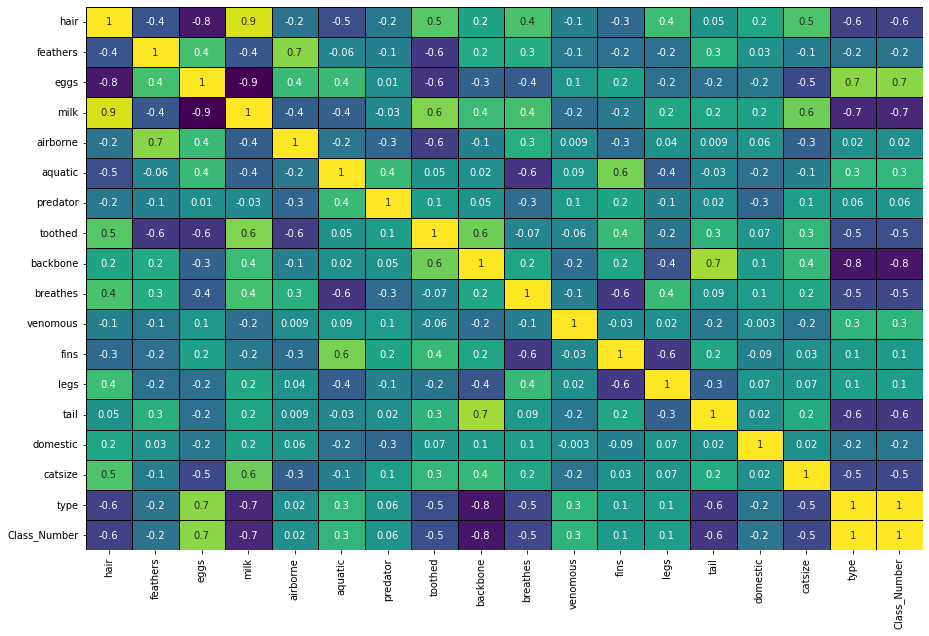

In [17]:
# Having a look at the correlation matrix

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(zoo.corr(), annot=True, fmt='.1g', cmap="viridis", cbar=False, linewidths=0.5, linecolor='black')

Text(0.5, 1.0, 'Features for the Animals')

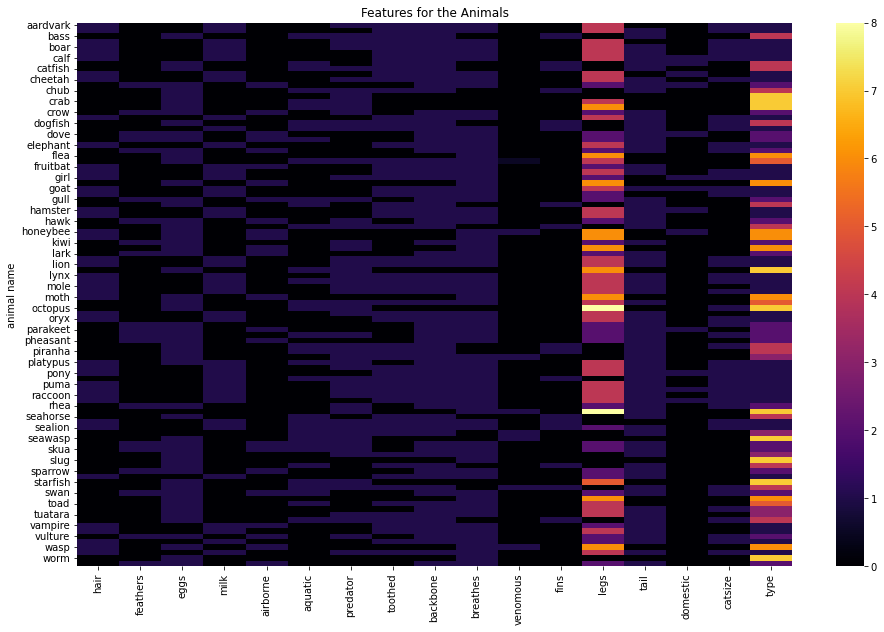

In [26]:
zoo_df_temp = zoo.drop(['Class_Type','Class_Number'], axis=1)
zoo_df_temp = zoo_df_temp.groupby(by='animal name').mean()
plt.rcParams['figure.figsize'] = (16,10) 
sns.heatmap(zoo_df_temp, cmap="inferno")
ax = plt.gca()
ax.set_title("Features for the Animals")

We can also see if there are any trends or correlations in the data using a heatmap.

As mentioned previously, we will want to treat the legs columns differently as it does not present data the same way as the remaining columns. So, we will create a column has_legs that checks if an animal has legs (1) or not (0).

In [28]:
zoo_df = zoo.copy()
zoo_df['has_legs'] = np.where(zoo_df['legs']>0,1,0)
zoo_df = zoo_df[['animal name','hair','feathers','eggs','milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes','venomous','fins','legs','has_legs','tail','domestic','catsize','Class_Number','Class_Type']]
zoo_df.head()

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,has_legs,tail,domestic,catsize,Class_Number,Class_Type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,0,1,1,Mammal
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,1,0,1,1,Mammal
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,0,1,0,0,4,Fish
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,0,1,1,Mammal
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,1,0,1,1,Mammal


Text(0.5, 1.0, 'Features for the Animals')

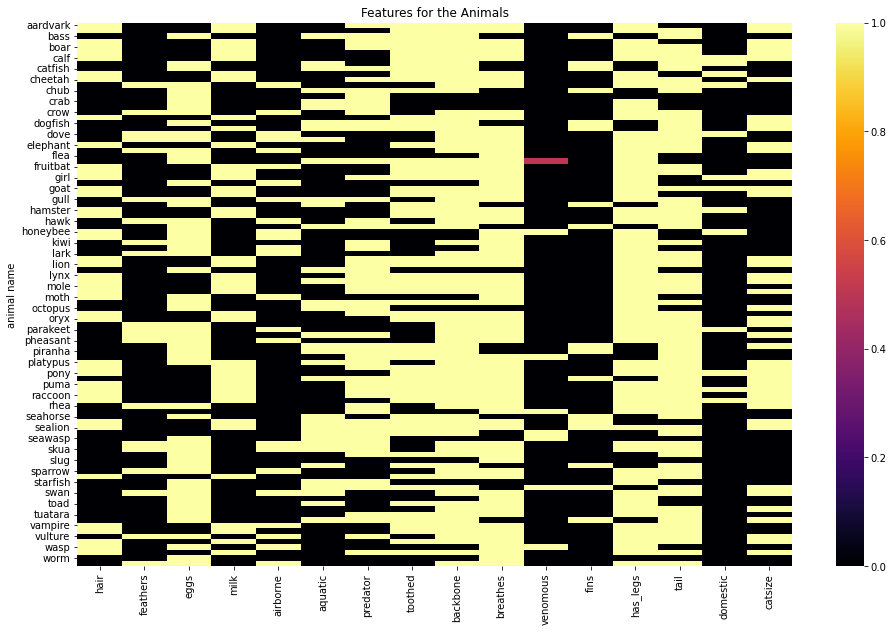

In [29]:
zoo_df_temp = zoo_df.drop(['legs','Class_Number','Class_Type'], axis=1)
zoo_df_temp = zoo_df_temp.groupby(by='animal name').mean()
plt.rcParams['figure.figsize'] = (16,10) 
sns.heatmap(zoo_df_temp, cmap="inferno")
ax = plt.gca()
ax.set_title("Features for the Animals")

In [30]:
zoo.columns

Index(['animal name', 'hair', 'feathers', 'eggs', 'milk', 'airborne',
       'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous',
       'fins', 'legs', 'tail', 'domestic', 'catsize', 'type', 'Class_Number',
       'Class_Type'],
      dtype='object')

Text(0.5, 1.0, 'Histogram of Classes')

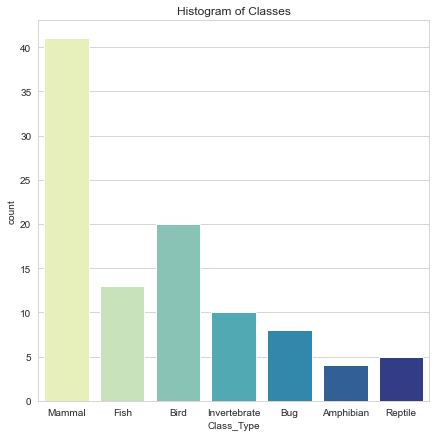

In [31]:
# Set default plot grid
sns.set_style('whitegrid')
# Plot histogram of classes
plt.rcParams['figure.figsize'] = (7,7)
sns.countplot(zoo['Class_Type'], palette='YlGnBu')
ax = plt.gca()
ax.set_title("Histogram of Classes")

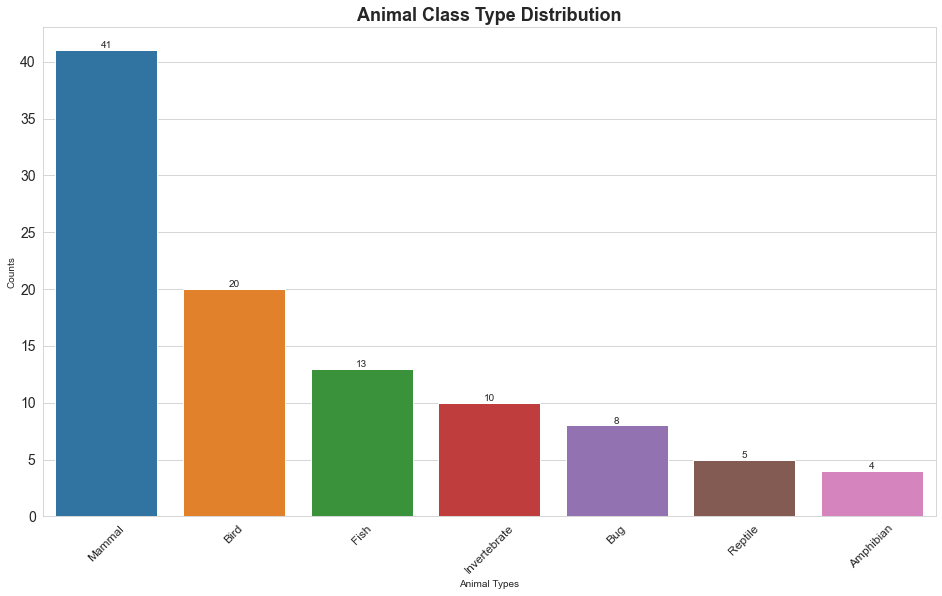

In [32]:
plt.figure(figsize = (16,9))
ax = sns.barplot(x = zoo['Class_Type'].value_counts().index.tolist(), y = zoo['Class_Type'].value_counts().tolist())
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 45, fontsize = 12)
plt.title("Animal Class Type Distribution",  fontsize = 18, fontweight = 'bold')
plt.xlabel('Animal Types')
plt.ylabel('Counts')
for i in ax.containers:
    ax.bar_label(i,)

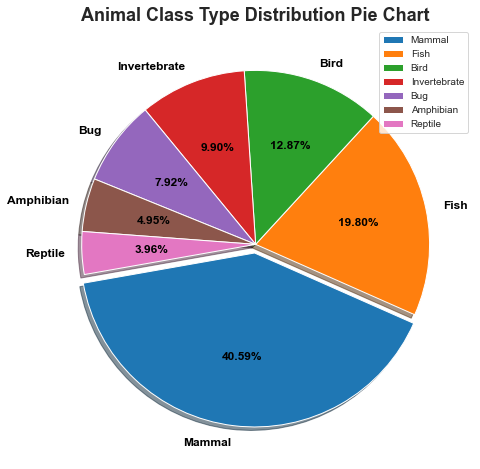

In [33]:
plt.figure(figsize = (12,8))
plt.pie(zoo['Class_Type'].value_counts(),
       labels=zoo.Class_Type.unique(),
       explode = [0.05,0.0,0.0,0.0,0.0,0.0,0.0],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 190,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    'rotation':'0',
                   'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Animal Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

The 7 Class Types are:

**`1. Mammal`**

**`2. Fish`**

**`3. Bird`**

**`4. Invertebrate`**

**`5. Bug`**

**`6. Amphibian`**

**`7. Reptile`**

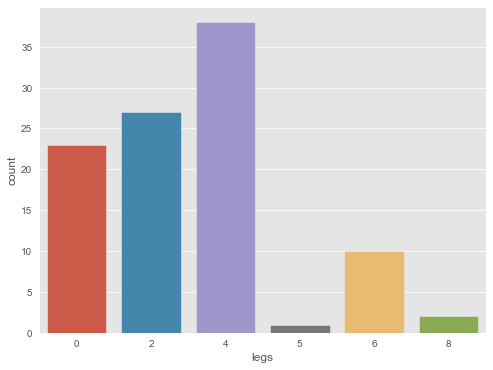

In [34]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(zoo["legs"]);

+ Most of the animals have 4 legs
+ Least number of animals have 5 legs

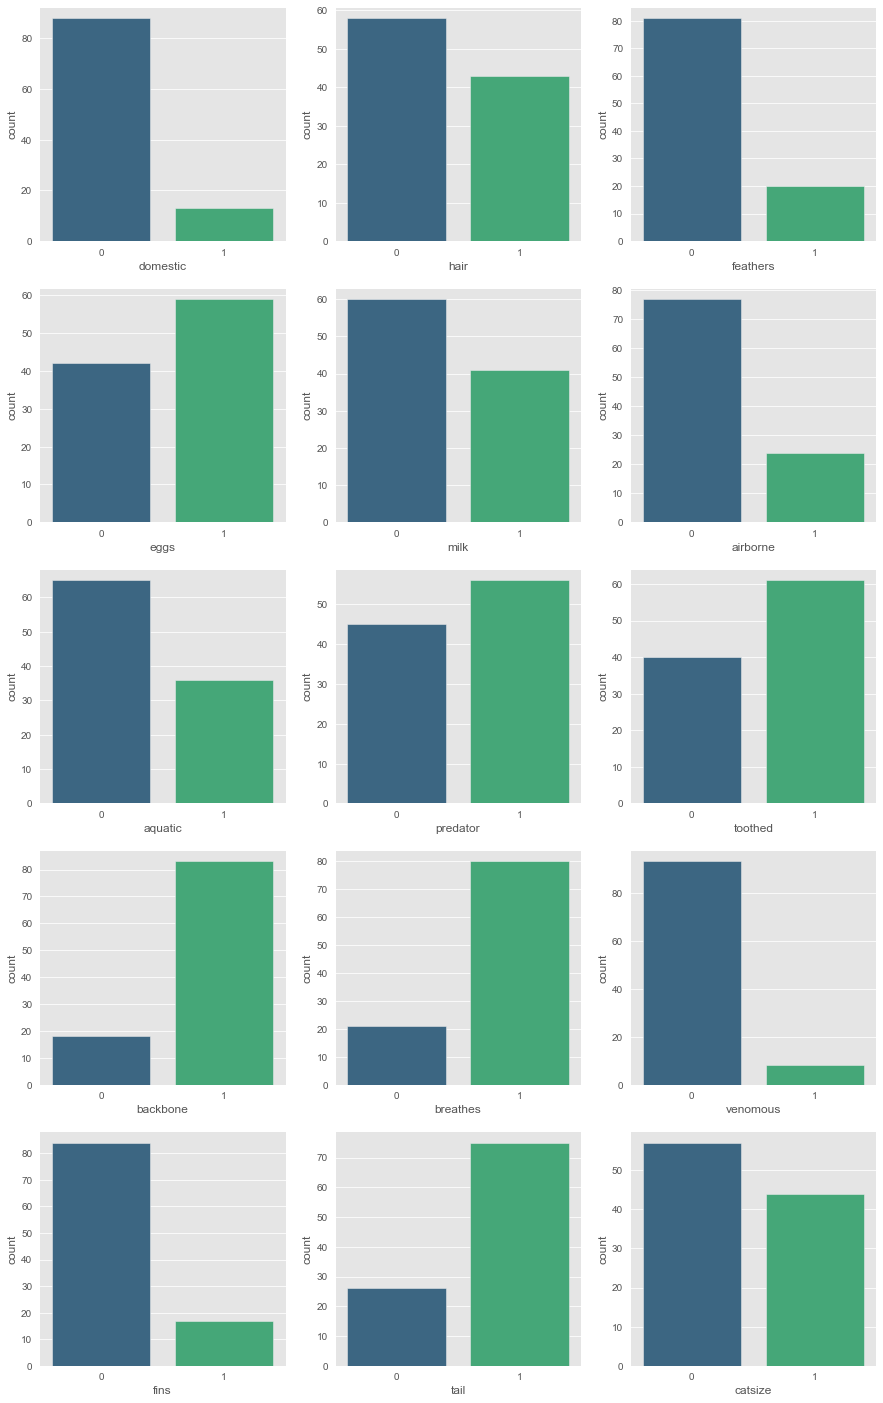

In [35]:
plt.style.use("ggplot")
fig, ax =plt.subplots(5,3, figsize=(15,25)) 

sns.countplot(zoo["domestic"], palette="viridis", ax=ax[0,0])
sns.countplot(zoo["hair"], palette="viridis", ax=ax[0,1])
sns.countplot(zoo["feathers"], palette="viridis", ax=ax[0,2])

sns.countplot(zoo["eggs"], palette="viridis", ax=ax[1,0])
sns.countplot(zoo["milk"], palette="viridis", ax=ax[1,1])
sns.countplot(zoo["airborne"], palette="viridis", ax=ax[1,2])

sns.countplot(zoo["aquatic"], palette="viridis", ax=ax[2,0])
sns.countplot(zoo["predator"], palette="viridis", ax=ax[2,1])
sns.countplot(zoo["toothed"], palette="viridis", ax=ax[2,2])

sns.countplot(zoo["backbone"], palette="viridis", ax=ax[3,0])
sns.countplot(zoo["breathes"], palette="viridis", ax=ax[3,1])
sns.countplot(zoo["venomous"], palette="viridis", ax=ax[3,2])

sns.countplot(zoo["fins"], palette="viridis", ax=ax[4,0])
sns.countplot(zoo["tail"], palette="viridis", ax=ax[4,1])
sns.countplot(zoo["catsize"], palette="viridis", ax=ax[4,2]);

## 4. Data Pre-Processing<a class="anchor" id="4"></a>

In [37]:
zoo.drop(['Class_Type','animal name','Class_Number'], axis=1, inplace=True)

In [38]:
zoo.head(1)

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1


## Test Train Split and Cross Validation methods<a class="anchor" id="4.1"></a>



***Train Test Split*** : To have unknown datapoints to test the data rather than testing with the same points with which the model was trained. This helps capture the model performance much better.



In [41]:
x = zoo.drop('type',axis=1)
y = zoo[['type']]

In [42]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [43]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (70, 16)
Shape of X_test:  (31, 16)
Shape of y_train:  (70, 1)
Shape of y_test (31, 1)


## 5. How to choose the value for K?<a class="anchor" id="5"></a>
K is a crucial parameter in the KNN algorithm. Some suggestions for choosing K Value are:



### 5.1 Grid search for choosing the best Value of K<a class="anchor" id="5.1"></a> 

In [44]:
# Get score for different values of n
k_list = np.arange(1, 40, 2)
mean_scores = []
accuracy_list = []
error_rate = []

for i in k_list:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    pred_i = pred_i.reshape(31,1)
    score = cross_val_score(knn,x_train, y_train,cv=10)
    mean_scores.append(np.mean(score))
    error_rate.append(np.mean(pred_i != y_test))

In [45]:
n_neighbors = np.array([2*i+1 for i in range(1,20)])
param_grid = dict(n_neighbors=n_neighbors)
n_neighbors

array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39])

In [46]:
model = KNeighborsClassifier()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv =10)
grid.fit(x, y)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39])})

In [47]:
print(grid.best_score_)
print(grid.best_params_)

0.95
{'n_neighbors': 3}


### 5.2 Visualizing the CV results<a class="anchor" id="5.2"></a>

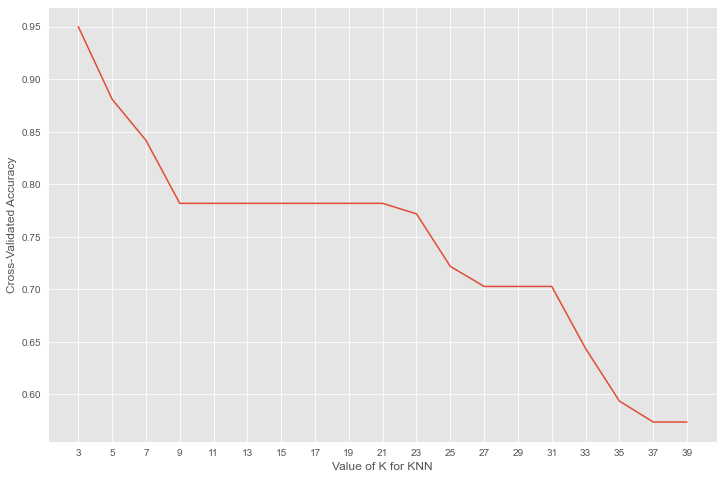

In [48]:
import matplotlib.pyplot as plt 
%matplotlib inline
# choose k between 1 to 40
k_range = np.array([2*i+1 for i in range(1,20)])
k_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x, y, cv=10)
    k_scores.append(scores.mean())
# plot to see clearly
plt.figure(figsize=(12,8))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(k_range)
plt.show()

In [49]:
pd.DataFrame(k_scores).sort_values(0,ascending=False).head(10)

,0
0,0.950000
1,0.880909
2,0.841818
6,0.781818
8,0.781818
7,0.781818
9,0.781818
5,0.781818
4,0.781818
3,0.781818


##### We can either take K = 9 or 3

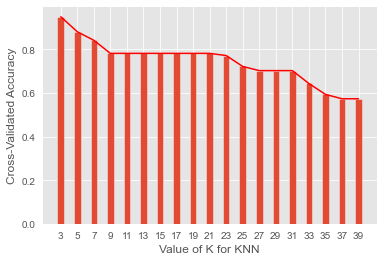

<Figure size 864x576 with 0 Axes>

In [50]:
import matplotlib.pyplot as plt 
%matplotlib inline
# choose k between 1 to 20
k_range = [2*i+1 for i in range(1,20)]
k_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x, y, cv=10)
    k_scores.append(scores.mean())
# plot to see clearly
plt.bar(k_range, k_scores)
plt.plot(k_range, k_scores, color='red')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(k_range)
plt.figure(figsize=(12,8))
plt.show()

Text(0, 0.5, 'Error Rate')

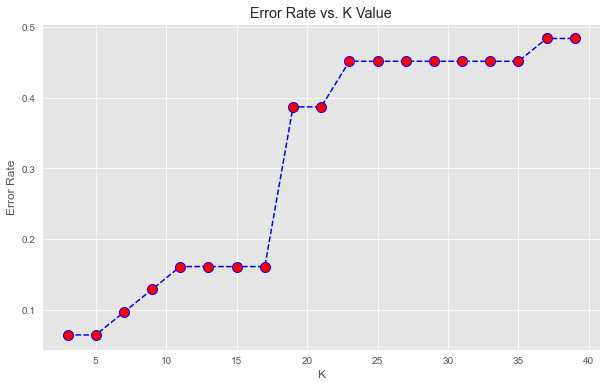

In [51]:
error_rate = []

# Will take some time
k_range = [i for i in range(3,40, 2)]
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    pred_i = pred_i.reshape(31,1)
    error_rate.append(np.mean(pred_i != y_test))
plt.figure(figsize=(10,6))
plt.plot([i for i in range(3,40, 2)],error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

Here we can see that that after K>3 the error rate just tends to hover around 0-0.5 Let's retrain the model with that and check the classification report!

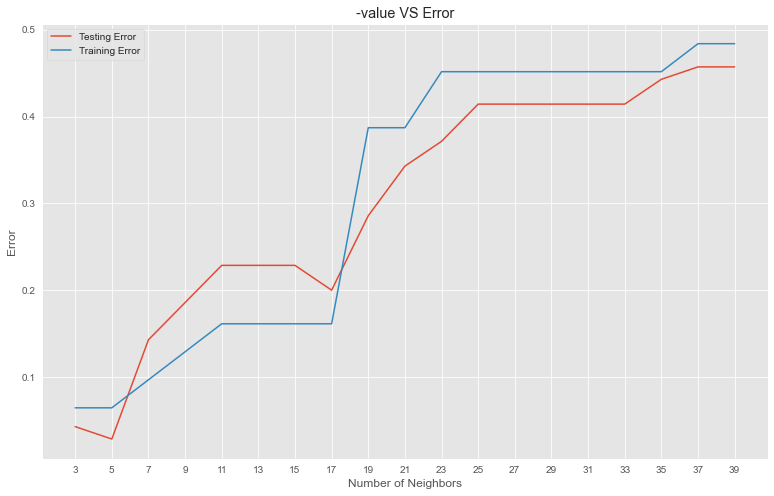

In [52]:
error1= []
error2= []
k_range = [i for i in range(3,40, 2)]
for k in k_range:
    knn= KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    y_pred1= knn.predict(x_train)
    y_pred1 = y_pred1.reshape(70,1)
    error1.append(np.mean(y_train!= y_pred1))
    y_pred2= knn.predict(x_test)
    y_pred2 = y_pred2.reshape(31,1)
    error2.append(np.mean(y_test!= y_pred2))
# Plot
plt.figure(figsize=[13,8])
plt.plot(k_range, error1, label = 'Testing Error')
plt.plot(k_range, error2, label = 'Training Error')
plt.legend()
plt.title('-value VS Error')
plt.xlabel('Number of Neighbors')
plt.ylabel('Error')
plt.xticks(k_range)
plt.show()

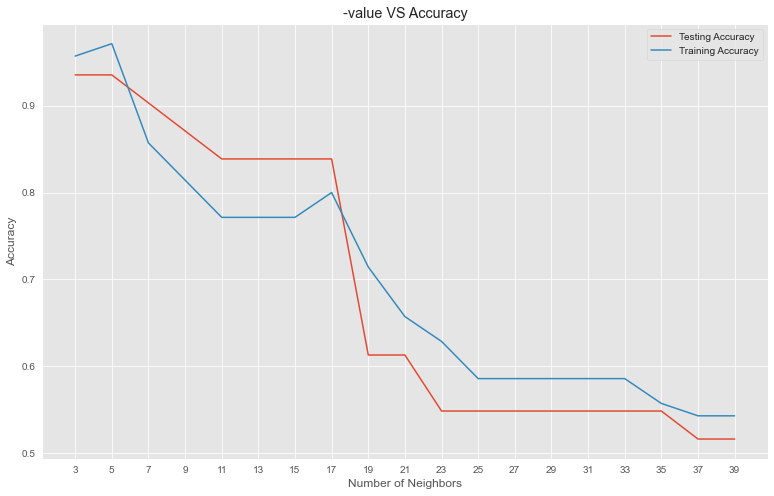

In [53]:
train_accuracy = []
test_accuracy = []

k_range = [i for i in range(3,40, 2)]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn.fit(x_train,y_train)
    #train accuracy
    train_accuracy.append(knn.score(x_train,y_train))
    # test accuracy
    test_accuracy.append(knn.score(x_test,y_test))
# Plot
plt.figure(figsize=[13,8])
plt.plot(k_range, test_accuracy, label = 'Testing Accuracy')
plt.plot(k_range, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('-value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.savefig('graph.png')
plt.show()

##### The best value of K is 3 or 5 lets check for these value in classifiaction Report

### 6. Applying KNN<a class="anchor" id="6"></a>

### Predictions and Evaluations<a class="anchor" id="6.1"></a>
Let's evaluate our KNN model!

#### 6.2 Applying KNN using K=3<a class="anchor" id="6.2"></a>

In [54]:
# NOW WITH K=3
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(x_train,y_train)
pred = knn.predict(x_test)

print('WITH K=3')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=3


[[11  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0]
 [ 0  0  0  2  0  0  0]
 [ 0  0  0  7  0  0  0]
 [ 0  0  0  0  1  0  0]
 [ 0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  2]]


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         2
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2

    accuracy                           0.94        31
   macro avg       0.83      0.86      0.84        31
weighted avg       0.89      0.94      0.91        31



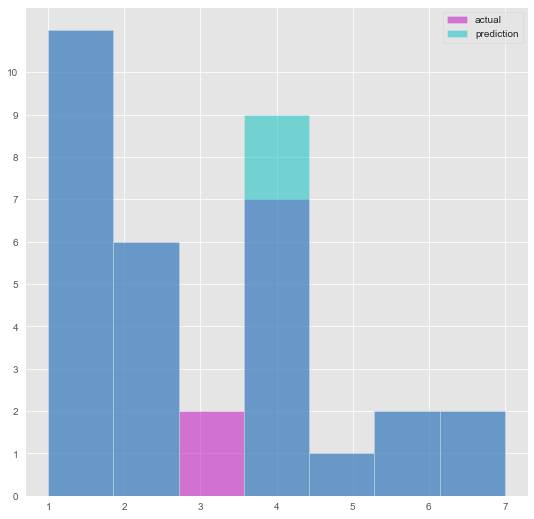

In [55]:
plt.rcParams['figure.figsize'] = (9,9) 
_, ax = plt.subplots()
ax.hist(y_test, color = 'm', alpha = 0.5, label = 'actual', bins=7)
ax.hist(pred, color = 'c', alpha = 0.5, label = 'prediction', bins=7)
ax.yaxis.set_ticks(np.arange(0,11))
ax.legend(loc = 'best')
plt.show()

#### 6.3  Applying KNN using K=5<a class="anchor" id="6.3"></a>

In [56]:
# NOW WITH K=5
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(x_train,y_train)
pred = knn.predict(x_test)

print('WITH K=5')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH K=5


[[11  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0]
 [ 0  0  0  2  0  0  0]
 [ 0  0  0  7  0  0  0]
 [ 0  0  0  0  1  0  0]
 [ 0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  2]]


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         6
           3       0.00      0.00      0.00         2
           4       0.78      1.00      0.88         7
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2

    accuracy                           0.94        31
   macro avg       0.83      0.86      0.84        31
weighted avg       0.89      0.94      0.91        31



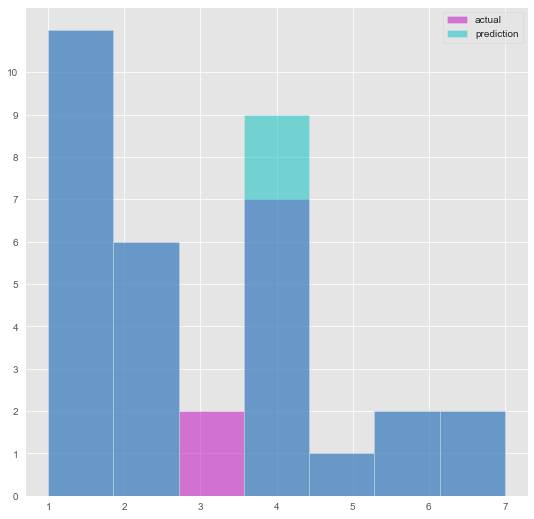

In [57]:
plt.rcParams['figure.figsize'] = (9,9) 
_, ax = plt.subplots()
ax.hist(y_test, color = 'm', alpha = 0.5, label = 'actual', bins=7)
ax.hist(pred, color = 'c', alpha = 0.5, label = 'prediction', bins=7)
ax.yaxis.set_ticks(np.arange(0,11))
ax.legend(loc = 'best')
plt.show()

In [59]:
# Select columns to add to X and y sets
features = list(zoo_df.columns.values)
features.remove('legs')
features.remove('Class_Type')
features.remove('Class_Number')
features.remove('animal name')
X2 = zoo_df[features]
y2 = zoo_df['Class_Type']
# Split X and y into train and test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,random_state = 0)

In [60]:
# NOW WITH K=5
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X2_train,y2_train)
pred = knn.predict(X2_test)

print('WITH K=5')
print('\n')
print(confusion_matrix(y2_test,pred))
print('\n')
print(classification_report(y2_test,pred))

WITH K=5


[[ 1  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0]
 [ 0  0  2  0  0  0  0]
 [ 0  0  0  5  0  0  0]
 [ 0  0  0  0  2  0  0]
 [ 0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  1]]


              precision    recall  f1-score   support

   Amphibian       1.00      1.00      1.00         1
        Bird       1.00      1.00      1.00         5
         Bug       1.00      1.00      1.00         2
        Fish       1.00      1.00      1.00         5
Invertebrate       1.00      1.00      1.00         2
      Mammal       1.00      1.00      1.00        10
     Reptile       1.00      1.00      1.00         1

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



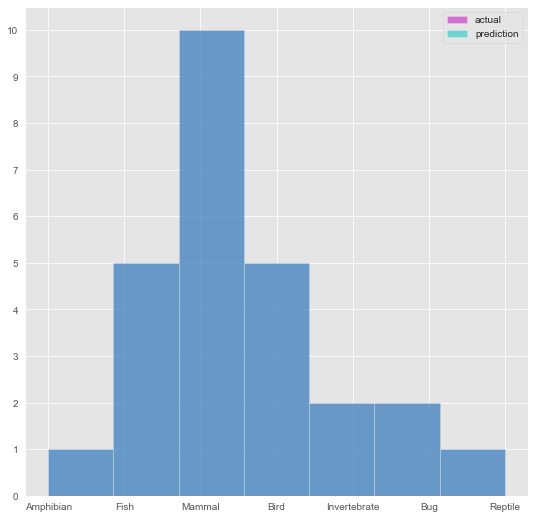

In [61]:
plt.rcParams['figure.figsize'] = (9,9) 
_, ax = plt.subplots()
ax.hist(y2_test, color = 'm', alpha = 0.5, label = 'actual', bins=7)
ax.hist(pred, color = 'c', alpha = 0.5, label = 'prediction', bins=7)
ax.yaxis.set_ticks(np.arange(0,11))
ax.legend(loc = 'best')

plt.show()

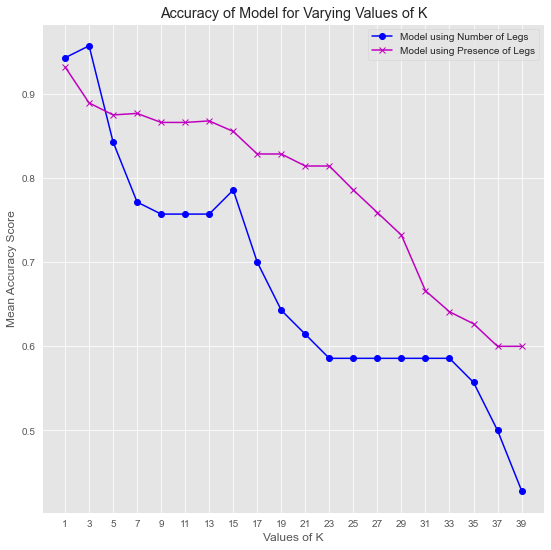

In [62]:
# Get score for different values of n
k_list = np.arange(1, 40, 2)
mean_scores2 = []
accuracy_list2 = []
error_rate2 = []

for i in k_list:
    knn2 = KNeighborsClassifier(n_neighbors=i)
    knn2.fit(X2_train,y2_train)
    pred_i = knn2.predict(X2_test)
    score = cross_val_score(knn2,X2_train, y2_train,cv=10)
    mean_scores2.append(np.mean(score))
    error_rate2.append(np.mean(pred_i != y2_test))
    
# Plot n values and average accuracy scores
plt.plot(k_list,mean_scores, color='b',marker='o', label='Model using Number of Legs')
plt.plot(k_list,mean_scores2, color='m',marker='x', label='Model using Presence of Legs')

# Added titles and adjust dimensions
plt.title('Accuracy of Model for Varying Values of K')
plt.xlabel("Values of K")
plt.ylabel("Mean Accuracy Score")
plt.xticks(k_list)
plt.legend()
plt.rcParams['figure.figsize'] = (12,12) 

plt.show()

ValueError: x and y must have same first dimension, but have shapes (20,) and (19, 1)

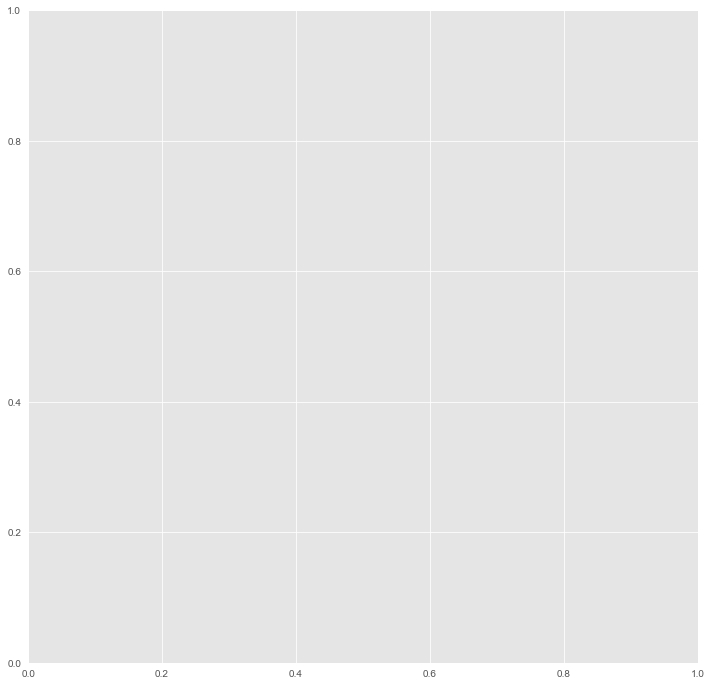

In [63]:
# Plot n values and average accuracy scores
plt.plot(k_list,error_rate, color='r', marker = 'o', label='Model using Number of Legs')
plt.plot(k_list,error_rate2, color='c', marker = 'x', label='Model using Presence of Legs')

# Added titles and adjust dimensions
plt.title('Error Rate for Model for Varying Values of K')
plt.xlabel("Values of K")
plt.ylabel("Error Rate")
plt.xticks(k_list)
plt.legend()
plt.rcParams['figure.figsize'] = (12,12) 

plt.show()